# ENTREGA 2

Objetivo: Cargar archivo `train.csv`, y realizar limpieza y preprocesado de datos.

## 1. Datos faltantes

In [1]:
import pandas as pd
import numpy as np
import gdown

# Descargar el train
file_id = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'train.csv', quiet=False)

# Cargar datos
df = pd.read_csv("train.csv")  # Asegúrate de que el archivo esté disponible

# Identificar columnas con valores faltantes
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

print(f"\n🔎 Se encontraron {len(missing_data)} columnas con datos faltantes:\n")

# Análisis y recomendaciones
for col in missing_data.index:
    print("="*60)
    print(f"** Columna: {col} **")

    dtype = df[col].dtype
    print(f"Tipo de dato: {'categórico' if dtype == 'object' else 'numérico'} ({dtype})")

    # Contar frecuencias de los valores NO nulos
    value_counts = df[col].value_counts(dropna=True)

    print("Distribución de valores:")
    for val, count in value_counts.items():
        val_str = str(val) if pd.notnull(val) else "Sin dato"
        print(f" - {val_str}: {count}")

    # Número de nulos
    n_missing = df[col].isnull().sum()
    perc_missing = n_missing / len(df) * 100
    print(f"❌ Valores faltantes: {n_missing} ({perc_missing:.2f}%)")

    # Recomendación automática según tipo y cantidad
    if perc_missing > 60:
        action = "⚠️ Tiene demasiados valores faltantes. Considera eliminar la columna."
    elif dtype == 'object':
        if value_counts.shape[0] <= 10:
            action = "✅ Pocas categorías. Pocos faltantes. Imputar con la moda o crear categoría 'missing'."
        else:
            action = "✅ Muchas categorías. Pocos faltantes. Agrupar o imputar con 'missing'."
    else:
        if perc_missing < 5:
            action = "✅ Pocos faltantes. Imputar con media o mediana."
        else:
            action = "😵‍💫 Faltantes moderados. Imputar por media, mediana o regresión."

    print(f"** Recomendación de limpieza: {action} **")
    print("="*60 + "\n")


Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=cee691b3-b8f6-421c-9c25-34339fddf556
To: /content/train.csv
100%|██████████| 144M/144M [00:01<00:00, 135MB/s]



🔎 Se encontraron 11 columnas con datos faltantes:

** Columna: ESTU_VALORMATRICULAUNIVERSIDAD **
Tipo de dato: categórico (object)
Distribución de valores:
 - Entre 1 millón y menos de 2.5 millones: 204048
 - Entre 2.5 millones y menos de 4 millones: 127430
 - Menos de 500 mil: 80263
 - Entre 500 mil y menos de 1 millón: 78704
 - Entre 4 millones y menos de 5.5 millones: 69736
 - Más de 7 millones: 68014
 - Entre 5.5 millones y menos de 7 millones: 38490
 - No pagó matrícula: 19528
❌ Valores faltantes: 6287 (0.91%)
** Recomendación de limpieza: ✅ Pocas categorías. Pocos faltantes. Imputar con la moda o crear categoría 'missing'. **

** Columna: ESTU_HORASSEMANATRABAJA **
Tipo de dato: categórico (object)
Distribución de valores:
 - Más de 30 horas: 249352
 - 0: 116550
 - Entre 11 y 20 horas: 115857
 - Entre 21 y 30 horas: 92693
 - Menos de 10 horas: 87191
❌ Valores faltantes: 30857 (4.46%)
** Recomendación de limpieza: ✅ Pocas categorías. Pocos faltantes. Imputar con la moda o crear c

## 2. Conclusiones del análisis de datos faltantes

### 2.1. General

* Todos los datos faltantes detectados son de tipo **categórico**.
* Las únicas columnas con datos numéricos son `ID`, `PERIODO`, `coef_1`, `coef_2`, `coef_3`, `coef_4`.
* La **cantidad de datos faltantes por columna es baja** (menos del 7%), por lo que **no es necesario eliminar columnas ni registros**.
* `FAMI_TIENEINTERNET.1` es una columna duplicada de `FAMI_TIENEINTERNET`.
  `➤ Acción: Eliminar columna duplicada.`

### 2.2. Métodos de imputación adecuados según el contexto

#### **2.2.1. Crear categoría `"missing"` (ausencia explícita)**

Se recomienda cuando:

* El valor tiene **importancia potencial**.
* No puede ser asumido sin inducir sesgo.
* La ausencia puede representar algo significativo.

* `ESTU_VALORMATRICULAUNIVERSIDAD`: No es razonable asumir una categoría de matrícula si no se reportó. `➤ Acción: Crear categoría "Sin información".`

* `ESTU_HORASSEMANATRABAJA`: La falta de respuesta podría estar asociada a condiciones laborales no formales. `➤ Acción: Crear categoría "Sin información".`

* `FAMI_ESTRATOVIVIENDA`: El estrato es un fuerte indicador socioeconómico. No debe asumirse arbitrariamente. `➤ Acción: Crear categoría "Sin información".`

* `FAMI_EDUCACIONPADRE`: Alta variedad de respuestas; mejor no asumir nada. `➤ Acción: Crear categoría "No sabe / No responde".`

* `FAMI_EDUCACIONMADRE`: Mismo razonamiento que la anterior. `➤ Acción: Crear categoría "No sabe / No responde".`

* `FAMI_TIENECOMPUTADOR`: Tener o no computador puede ser altamente informativo. `➤ Acción: Crear categoría "Sin información".`


#### **2.2.2. Imputación con la moda (valor más frecuente)**

Adecuado cuando:

* La columna tiene pocas categorías.
* El valor más frecuente representa una **mayoría aplastante**.
* El impacto en el modelo por asumir ese valor es bajo.

* `FAMI_TIENELAVADORA`: “Sí” es claramente dominante. `➤ Acción: Imputar con la moda → "Sí".`

* `ESTU_PAGOMATRICULAPROPIO`: Proporción pequeña de faltantes. Se puede asumir como "No". `➤ Acción: Imputar con la moda.`

#### **2.2.3. Casos dudosos (requieren prueba A/B o validación cruzada)**

Se puede optar por **imputar con moda** o **crear categoría "missing"**, según el modelo, o evaluar ambos métodos.

* `FAMI_TIENEINTERNET`: Dominancia clara de “Sí”, pero su importancia puede ser crítica para algunos análisis. `➤ Acción sugerida: Probar tanto imputación con "Sí" como categoría "Sin información".`

* `FAMI_TIENEAUTOMOVIL`: “No” es mayoría, pero tener carro es relevante en el contexto socioeconómico. `➤ Acción sugerida: Probar ambas estrategias — imputar "No" o crear categoría "Sin información".`

## 3. Limpieza y Preprocesado

In [2]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

In [3]:
# Descargar el train
file_id = '1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'train.csv', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY
From (redirected): https://drive.google.com/uc?id=1GxZjpmMXIHHWNvbp5_H7AeL1dQPvA4uY&confirm=t&uuid=cfd15370-b805-4ae5-aecd-8be56afba8e5
To: /content/train.csv
100%|██████████| 144M/144M [00:00<00:00, 187MB/s]


'train.csv'

In [4]:
# Cargar el conjunto de datos

df = pd.read_csv('train.csv')

# Eliminar columna duplicada

if 'FAMI_TIENEINTERNET.1' in df.columns:
    df.drop(columns=['FAMI_TIENEINTERNET.1'], inplace=True)

### 3.1. Manejo de valores faltantes

In [5]:
# Casos seguros

# 1. Categoría "Mising"

missing_replacements = { # Diccionario: columnas y valor de reemplazo
    'ESTU_VALORMATRICULAUNIVERSIDAD': 'Sin información',
    'ESTU_HORASSEMANATRABAJA': 'Sin información',
    'FAMI_ESTRATOVIVIENDA': 'Sin información',
    'FAMI_EDUCACIONPADRE': 'No sabe / No responde',
    'FAMI_EDUCACIONMADRE': 'No sabe / No responde',
    'FAMI_TIENECOMPUTADOR': 'Sin información'
}

for col, missing_value in missing_replacements.items(): # Aplicar reemplazo con categoría explícita
    df[col] = df[col].fillna(missing_value)


# 2. Moda

mode_columns = ['FAMI_TIENELAVADORA', 'ESTU_PAGOMATRICULAPROPIO'] # Columnas a imputar con la moda

for col in mode_columns:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)


In [6]:
# Verificar que no hay datos faltantes después del preprocesado

print("🔎 ¿Aún hay valores faltantes?")
print(df.isnull().sum().sort_values(ascending=False).head(10))  # top 10 por si acaso

🔎 ¿Aún hay valores faltantes?
FAMI_TIENEAUTOMOVIL               43623
FAMI_TIENEINTERNET                26629
ID                                    0
PERIODO                               0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_PRGM_ACADEMICO                   0
ESTU_HORASSEMANATRABAJA               0
ESTU_VALORMATRICULAUNIVERSIDAD        0
FAMI_ESTRATOVIVIENDA                  0
FAMI_EDUCACIONPADRE                   0
dtype: int64


#### 3.1.1 Casos Dudosos

**Comparar rendimiento (missing vs moda)**

In [7]:
# 1. Librerías adicionales

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# -------------------------------------------------------------------------------------------------------------

# 2. Preprocesamiento básico para comparación

# Copias de los dos DataFrames para prueba
df_missing_test = df.copy()
df_mode_test = df.copy()

# Aplicar imputación por categoría explícita ("missing")
df_missing_test['FAMI_TIENEINTERNET'] = df_missing_test['FAMI_TIENEINTERNET'].fillna('Sin información')
df_missing_test['FAMI_TIENEAUTOMOVIL'] = df_missing_test['FAMI_TIENEAUTOMOVIL'].fillna('Sin información')

# Aplicar imputación con la moda
for col in ['FAMI_TIENEINTERNET', 'FAMI_TIENEAUTOMOVIL']:
    moda = df_mode_test[col].mode()[0]
    df_mode_test[col] = df_mode_test[col].fillna(moda)

# -------------------------------------------------------------------------------------------------------------

# 3. Codificar las variables categóricas

def encode_dataframe(df, target):
    df_encoded = df.copy()
    le_dict = {}
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'object' and col != target:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            le_dict[col] = le
    return df_encoded

# -------------------------------------------------------------------------------------------------------------

# 4. Configurar modelo y validación

# Definir columna objetivo
target = 'RENDIMIENTO_GLOBAL'

# Filtrar columnas válidas (remover ID y otras numéricas irrelevantes si es necesario)
features = [col for col in df.columns if col not in ['ID', 'PERIODO', 'coef_1', 'coef_2', 'coef_3', 'coef_4', target]]

# Codificar datasets
df_missing_encoded = encode_dataframe(df_missing_test[features + [target]], target)
df_mode_encoded = encode_dataframe(df_mode_test[features + [target]], target)

# Separar X, y
X_missing = df_missing_encoded.drop(columns=[target])
y_missing = df_missing_encoded[target]

X_mode = df_mode_encoded.drop(columns=[target])
y_mode = df_mode_encoded[target]

# Modelo base
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Validación cruzada (3 folds)
scores_missing = cross_val_score(model, X_missing, y_missing, cv=3, scoring='accuracy')
scores_mode = cross_val_score(model, X_mode, y_mode, cv=3, scoring='accuracy')

# -------------------------------------------------------------------------------------------------------------

# 5. Resultados y conclusión

print("🔎 Resultados de validación cruzada (Accuracy promedio)")
print(f"Categoría 'missing': {scores_missing.mean():.4f}")
print(f"Moda:               {scores_mode.mean():.4f}")

if scores_missing.mean() > scores_mode.mean():
    print("\n✅ Conclusión: Es mejor imputar con categoría 'missing'.")
elif scores_missing.mean() < scores_mode.mean():
    print("\n✅ Conclusión: Es mejor imputar con la moda.")
else:
    print("\n😵‍💫 Conclusión: Ambos métodos tienen un rendimiento similar.")


🔎 Resultados de validación cruzada (Accuracy promedio)
Categoría 'missing': 0.3768
Moda:               0.3761

✅ Conclusión: Es mejor imputar con categoría 'missing'.


**Conclusión:**

- Para `FAMI_TIENEINTERNET` es mejor: imputar con una categoría explícita `"Sin información"`, ya que obtuvo un mayor accuracy promedio en validación cruzada (0.3780 vs 0.3769).
- Para `FAMI_TIENEAUTOMOVIL` es mejor: imputar también con la categoría `"Sin información"`, dado que se incluyó en el mismo experimento y mostró mejor rendimiento frente a la imputación por moda.

**Aplicar métodos que mejor tuvieron rendimiento:**

In [ ]:
# Imputar valor "Sin información" en las columnas seleccionadas
df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].fillna('Sin información')
df['FAMI_TIENEAUTOMOVIL'] = df['FAMI_TIENEAUTOMOVIL'].fillna('Sin información')
print(df[['FAMI_TIENEINTERNET', 'FAMI_TIENEAUTOMOVIL']].isnull().sum())

FAMI_TIENEINTERNET     0
FAMI_TIENEAUTOMOVIL    0
dtype: int64


In [ ]:
# Volver a verificar que no hay datos faltantes después del preprocesado

print("🔎 ¿Aún hay valores faltantes?")
print(df.isnull().sum().sort_values(ascending=False).head(10))

🔎 ¿Aún hay valores faltantes?
ID                                0
PERIODO                           0
ESTU_PRGM_ACADEMICO               0
ESTU_PRGM_DEPARTAMENTO            0
ESTU_VALORMATRICULAUNIVERSIDAD    0
ESTU_HORASSEMANATRABAJA           0
FAMI_ESTRATOVIVIENDA              0
FAMI_TIENEINTERNET                0
FAMI_EDUCACIONPADRE               0
FAMI_TIENELAVADORA                0
dtype: int64


### 3.2. Guardar dataset procesado

In [ ]:
# Guardar archivo limpio

df.to_csv("datos_procesados.csv", index=False)

### 3.3. Visualización

In [ ]:
# Mostrar información final

df.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


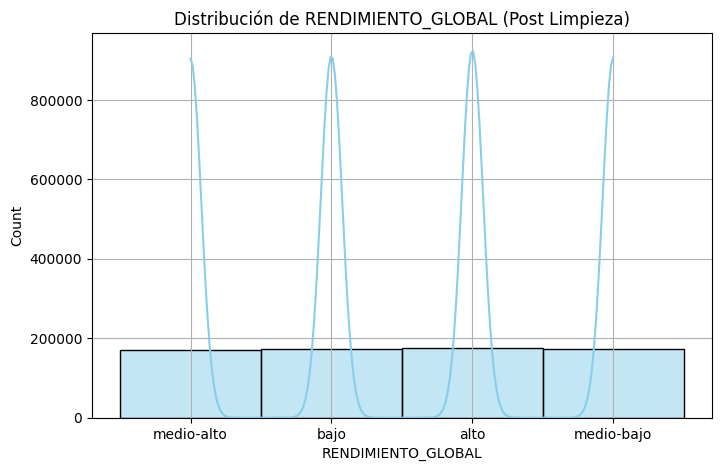

In [ ]:
# Visualización de resultados

if 'RENDIMIENTO_GLOBAL' in df.columns: # Se asegura que la variable exista
    plt.figure(figsize=(8,5))
    sns.histplot(df['RENDIMIENTO_GLOBAL'], kde=True, bins=30, color='skyblue')
    plt.title('Distribución de RENDIMIENTO_GLOBAL (Post Limpieza)')
    plt.grid(True)
    plt.show()